# Monte Carlo methods #

**Intro to using randomness to perform calculations: Monte Carlo counting and Monte Carlo integration**

This notebook looks at *Monte Carlo methods* (named for the Monaco city world-renowned for its casinos), a blanket term for using randomness to perform calculations. For our examples, we'll be using as a source of randomness the generic [`numpy.random.Generator.random()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.random.html) method (`rng.random()`).

The `rng.random()` function returns a random number uniformly distributed between zero and one. "Uniform" means that any number is equally likely. To see this, let's look at some example data.

First we need to import `numpy`, and then `matplotlib.pyplot` for the main plotting functions

In [153]:
# imports
import numpy as np
import matplotlib.pyplot as plt

The function `default_rng()` from `numpy.random` will create a `Generator` object:

In [154]:
rng = np.random.default_rng()

The `random` method of `rng` returns a random number between zero and one

In [155]:
rng.random()

0.9233298682818064

We can generate an array full of random numbers by using the `size` keyword argument:

In [156]:
rng.random(size = (3,3))

array([[0.11486897, 0.14119516, 0.39801569],
       [0.25990891, 0.18013915, 0.91771853],
       [0.25132653, 0.98526156, 0.49028041]])

We can look at a distribution of 100,000 outputs using `matplotlib`'s `hist` function to plot a histogram:

Text(0.5, 1.0, 'distribution of rng.random()')

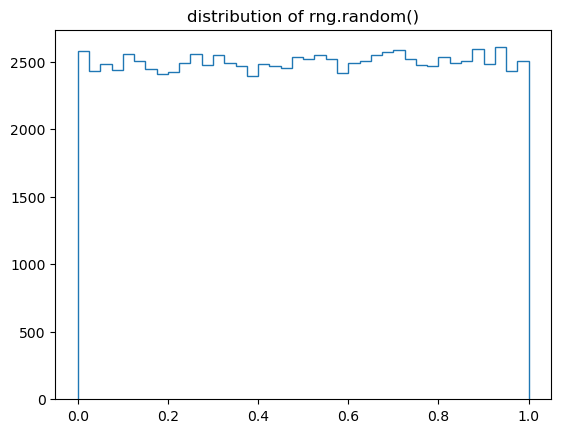

In [157]:
N = 100_000 # number of data points 

data = rng.random(N) # generate data and store in array called "data"

plt.figure() # create figure
plt.hist(data, bins = 40, histtype = 'step') # create histogram with 40 bins, with unfilled bars
plt.title('distribution of rng.random()')

As you can see, each one of the forty bins had approximately the same number of data points fall in it.

We can leverage this uniformity to perform some calculations. For example, if we randomly generate $(x,y)$ pairs we can uniformly spread points around the unit cube from $0\leq~x\leq1$ and $0\leq~y\leq1$:

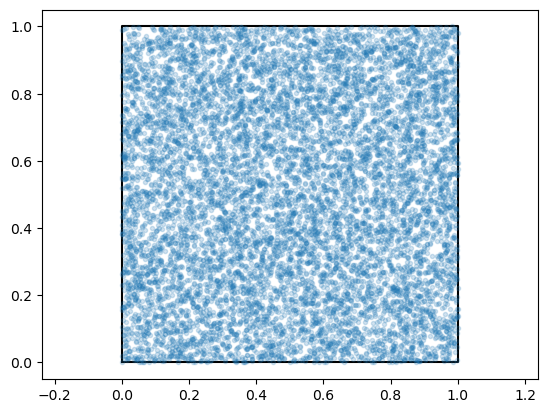

In [158]:
Npts = 10_000

xs, ys = rng.random(size = (2,Npts))

plt.figure()
plt.axis('equal')
plt.plot([0,0,1,1,0], [0,1,1,0,0], 'k')
plt.plot(xs, ys, '.', alpha = 0.2)

Now something interesting happens if we draw a quarter circle inside the square:

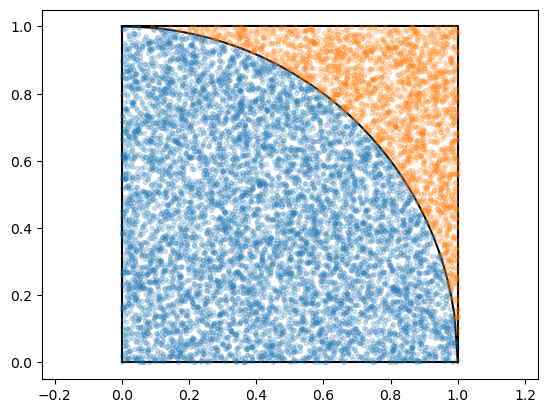

In [159]:
plt.figure()
plt.axis('equal')
plt.plot([0,0,1,1,0], [0,1,1,0,0], 'k')
plt.plot(np.linspace(0,1,100), np.sqrt(1-np.linspace(0,1,100)**2), 'k')

# inside circle: x^2 + y^2 < 1
inside = xs**2 + ys**2 < 1

# plot all the points inside the circle in blue
plt.plot(xs[inside], ys[inside], 'C0.', alpha = 0.2)

# plot all the points outside the circle in red
plt.plot(xs[~inside], ys[~inside], 'C1.', alpha = 0.2)

The fraction of blue points should just be the fraction of the area of the square covered by the circle:

$$ \frac{A_{circle}}{A_{square}} = \frac{\pi/4}{1^2} \approx \frac{N_{blue}}{N_{total}}$$

Using this formula, we can then approximate $\pi$:

In [160]:
pi_approx = 4*inside.sum()/inside.size

print(f'pi is approximately {pi_approx}')

pi is approximately 3.1224


If we keep doing this, we keep getting different approximations for pi. We can repeat this estimation process a large number of times, with different number of points per estimate, and plot histograms of the results:

In [161]:
# define a function to randomly generate a given number of points in the unit square and estimate the value of pi
def est_pi(N):
    xs, ys = rng.random(size = (2, N))
    pi_estimate = 4*(xs**2 + ys**2 < 1).sum()/N
    return pi_estimate

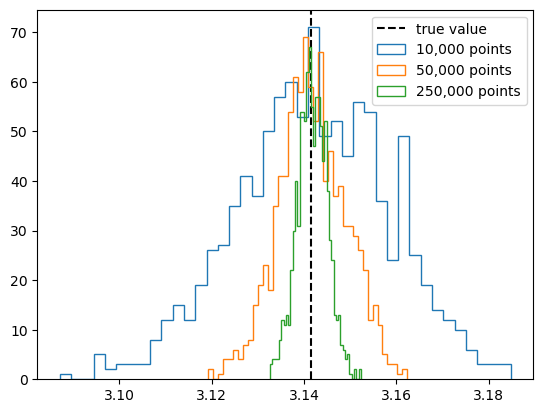

In [ ]:
N_estimates = 1000
N_points_list = [10_000, 50_000, 250_000]


plt.figure()
plt.axvline(np.pi, color = 'k', linestyle = 'dashed', label = 'true value')
estimates = np.zeros(N_estimates)
for N_points in N_points_list:
    for i in range(N_estimates):
        estimates[i] = est_pi(N_points)

    plt.hist(estimates, bins = 40, label = f'{N_points:,.0f} points', histtype = 'step')

plt.legend()

Unsurprisingly, the more data points we generate, the closer to the true value we get. But is there a way we can do better, with the same amount of randomness?

## Part 2: Monte Carlo integration ##

So far we've looked at the general premises of Monte Carlo "methods," but now we focus on Monte Carlo *integration*, which is using randomness to evaluate *any integral*.

Say we want to know $I$, the integral $I$ of a function $f(x)$ between $x=a$ and $x=b$:


$$ I = \int_a^b f(x)dx$$

If we want to evaluate this integral numerically, you might imagine breaking up the range of $x$ into $N$ little segments with endpoints $x_i$, with index $i$ running from $0$ to $N$, and with $x_0=a$ and $x_N = b$. Then we can add together all the $N$ little pieces $dI=f(x)dx$ by approximating them as $f(\bar{x}_i)\Delta x$, where $\bar{x}_i = (x_{i+1}+x_i)/2$ is the average value of $x$ in the segment and $\Delta x = x_{i+1} - x_i = \frac{b-a}{N}$ is the width of each segment:

$$I\approx \sum_{i=0}^{N-1} f(\bar{x}_i) \Delta x$$

As an example, consider the example function of $f(x)=\sqrt{1-x^2}$ from $x=0$ to $x=1$:

$$ I = \int_0^1 \sqrt{1-x^2} dx$$

The exact indefinite integral is:

$$\int \sqrt{1-x^2} dx = \frac{1}{2}x\sqrt{1-x^2} - \arctan\left(\sqrt{\frac{1-x}{1+x}}\right)$$

so

$$ I = \arctan\left(1\right) = \frac{\pi}{4}\approx0.7853981633974483$$

which we can recognize as the area of the quarter circle defined by $\sqrt{1-x^2}$.



### Numerical Integration on a Grid ###

To estimate $I$ numerically, we can split the range $0\leq x\leq1$ into 100 segments:

In [163]:
N = 20 # number of segments

# function to evaluate
def func(x):
    return np.sqrt(1 - x**2)

# note to get 100 segments, we need 101 points (one extra for the upper bound of the last segment)
xs = np.linspace(0, 1, N+1, endpoint = True) 

xbar = (xs[1:] + xs[:-1])/2
dx = 1/N

fs = func(xbar)

I_approx = fs.sum()*dx

print(I_approx)

0.78635764716976


What we've done is approximated the area under $f(x)$ as a series of rectangles:

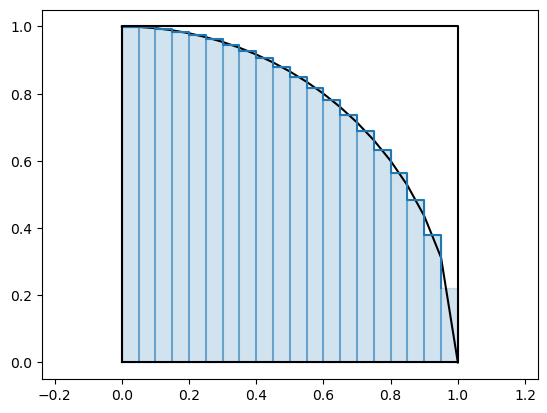

In [164]:
plt.figure()
plt.axis('equal')
plt.plot(xs, func(xs), 'k') # plot the circle in black

# plot 'steps' of the function values fs, where 'post' means that each step takes place after the plotted point (from x[i] to x[i+1])
plt.step(xs[:-1], fs, where = 'post', color = 'C0') 

# construct the corners of the rectangles for each segment
# (x0,x1,x1,x2,x2,x3,x3.... xN-1,xN-1,xN)
x_boxes = (np.array([xs, xs]).T).flatten()[1:-1] 
# (f0,f0,f1,f1,f2,f2...fN-1,fN-1)
y_boxes = (np.array([fs,fs]).T).flatten()

plt.fill_between(x_boxes, 0, y_boxes, color = 'C0', alpha = 0.2)
for x, f in zip(xs,fs):
    plt.plot(2*[x], [0,f], color = 'C0', alpha = 0.6)
#plt.plot(x_boxes, y_boxes, 'k')
plt.plot([0,0,1,1,0], [0,1,1,0,0], 'k')

There are of course further ways to refine numerical integrals of this sort, but they all share this common feature of dividing the domain of integration into a grid and evaluating the function of interest on that grid. 

### Monte Carlo Integration ###

Now, instead of regularly spacing out the $\bar{x}_i$, Monte Carlo integration uses a randomly generated set of $N$ values, $x_k$:

$$I\approx \sum_{k=0}^{N-1} f(x_k) \Delta x = \frac{b-a}{N} \sum_k f(x_k)$$

Now, instead of a series of evenly-spaced rectangles, we approximate the area under the curve of $f(x)$ as a set of randomly-scattered rectangles. For the example of $f=\sqrt{1-x^2}$:

0.8500563084564444


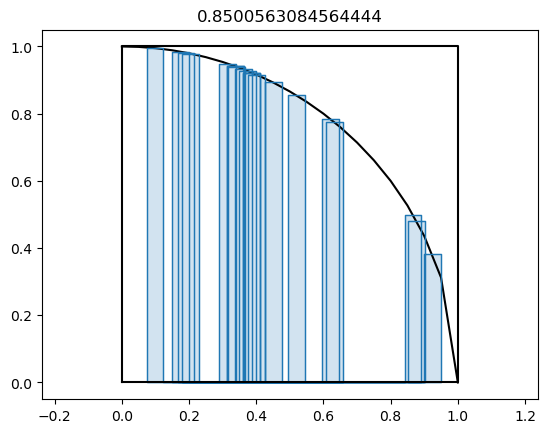

In [226]:
# randomly generate x values
xk = rng.random(size = N)

# calculate function values
fk = func(xk)

I_approx_MC = fk.sum()*dx
print(I_approx_MC)


plt.figure()
plt.axis('equal')
plt.plot(xs, func(xs), 'k') # plot the circle in black

plt.title(I_approx_MC)
# construct the corners of the rectangles for random xk
# (x0,x1,x1,x2,x2,x3,x3.... xN-1,xN-1,xN)
x_boxes = (np.array([xk-dx/2,xk-dx/2,xk+dx/2,xk+dx/2]).T).flatten()
# (f0,f0,f1,f1,f2,f2...fN-1,fN-1)
y_boxes = (np.array([N*[0], fk, fk, N*[0]]).T).flatten()
plt.plot(x_boxes, y_boxes, color = 'C0', linewidth = 1)
plt.fill_between(x_boxes, 0, y_boxes, color = 'C0', alpha = 0.2)
#plt.plot(x_boxes, y_boxes, 'k')
plt.plot([0,0,1,1,0], [0,1,1,0,0], 'k')

In a one-dimensional case like this, there's usually no advantage to using MC methods over the deterministic integral described above. However, for higher-dimensional integrals MC methods become much more effective as a way to populate the full range of details in high-dimensional spaces without needing expensive high-dimensional grids (which get very large very fast, especially if a high level of detail is needed).

In [174]:
# compare 
def est_pi_compare(N):
    data = rng.random(size = N)
    xs = data[::2]
    ys = data[1::2]
    estimate1 = 4*(xs**2 + ys**2 < 1).sum()/(N/2)
    estimate2 = 4*np.sqrt(1-data**2).sum()/N
    return estimate1, estimate2

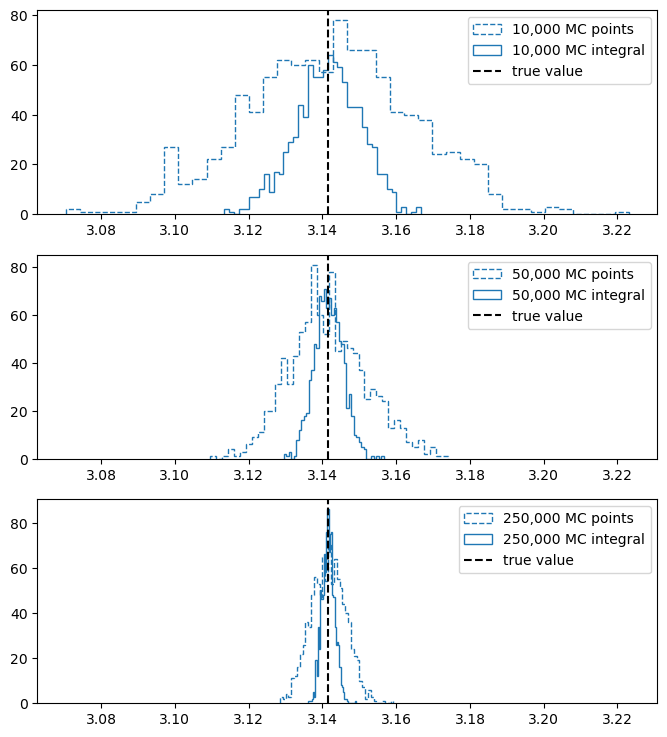

In [185]:
N_estimates = 1000
N_points_list = [10_000, 50_000, 250_000]


fig, axs = plt.subplots(nrows = len(N_points_list), figsize = (8, 3*len(N_points_list)))
estimates = np.zeros(N_estimates)
estimates2 = np.zeros(N_estimates)
for ax, N_points in zip(axs, N_points_list):
    for i in range(N_estimates):
        estimates[i], estimates2[i] = est_pi_compare(N_points)

    h = ax.hist(estimates, bins = 40, label = f'{N_points:,.0f} MC points', histtype = 'step', linestyle = 'dashed')[-1][0]

    ax.hist(estimates2, bins = 40, label = f'{N_points:,.0f} MC integral', histtype = 'step', color = h.get_edgecolor())

    ax.axvline(np.pi, color = 'k', linestyle = 'dashed', label = 'true value')


    ax.legend()

    if N_points != N_points_list[0]:
        ax.set_xlim(ax_xlims)
    else:
        ax_xlims = ax.get_xlim()
# note that after we exit the loop, the "estimates" variable contains the estimates for 250,000 points

plt.legend()